# Interpolation to a structured grid from a cloud of points

First of all, we have a cloud of XYZ points and we want to predict a vertice of a 2D structured grid based on this cloud of points (I will abreviate that as CP and the structured grid as SG).

It's important to note that, the CP has 3 values which describes each point:
* the X value which represents the value in the X axis;
* the Y value which represents the value in the Y axis;
* The Z value which describes a property value (like temperature, or depth, or pressure, etc).

So, I'm going to use KNN (K-Nearest Neighbors) strategy to search for the nearest points of each vertice of the SG and I must predict the property value of that vertice. 

However if the nearest point of the vertice is too far away I will assume that point has to be blank (or in this case I will just put a zero value). I'm going to explain in the next sections how to apply this interpolation.

------
Obs: For more information about KNN algorithm please visit: 
* http://scikit-learn.org/stable/modules/neighbors.html
* https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
------


## Imports

In [1]:
# Imports
import math
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

## Loading the points and creating the structured grid

In [2]:
# Loading xyz map
correct_map = pd.read_csv('correct_map.xyz', sep=' ', dtype='d', header=None, names=['x', 'y', 'z'])
scattered_data_10000 = pd.read_csv('scattered_data_10000.xyz', sep=' ', dtype='d', header=None, names=['x', 'y', 'z'])

NI = 100
NJ = 100
number_neighbors = 5

# Creating grid points
x_grid = np.linspace(1, 10, NI)
y_grid = np.linspace(1, 10, NJ)

grid_points = pd.DataFrame()
grid_points['x'] = np.tile(x_grid, NJ)
grid_points['y'] = y_grid.repeat(NI)
grid_points['z'] = np.zeros(NI*NJ)

**Structured Grid:**

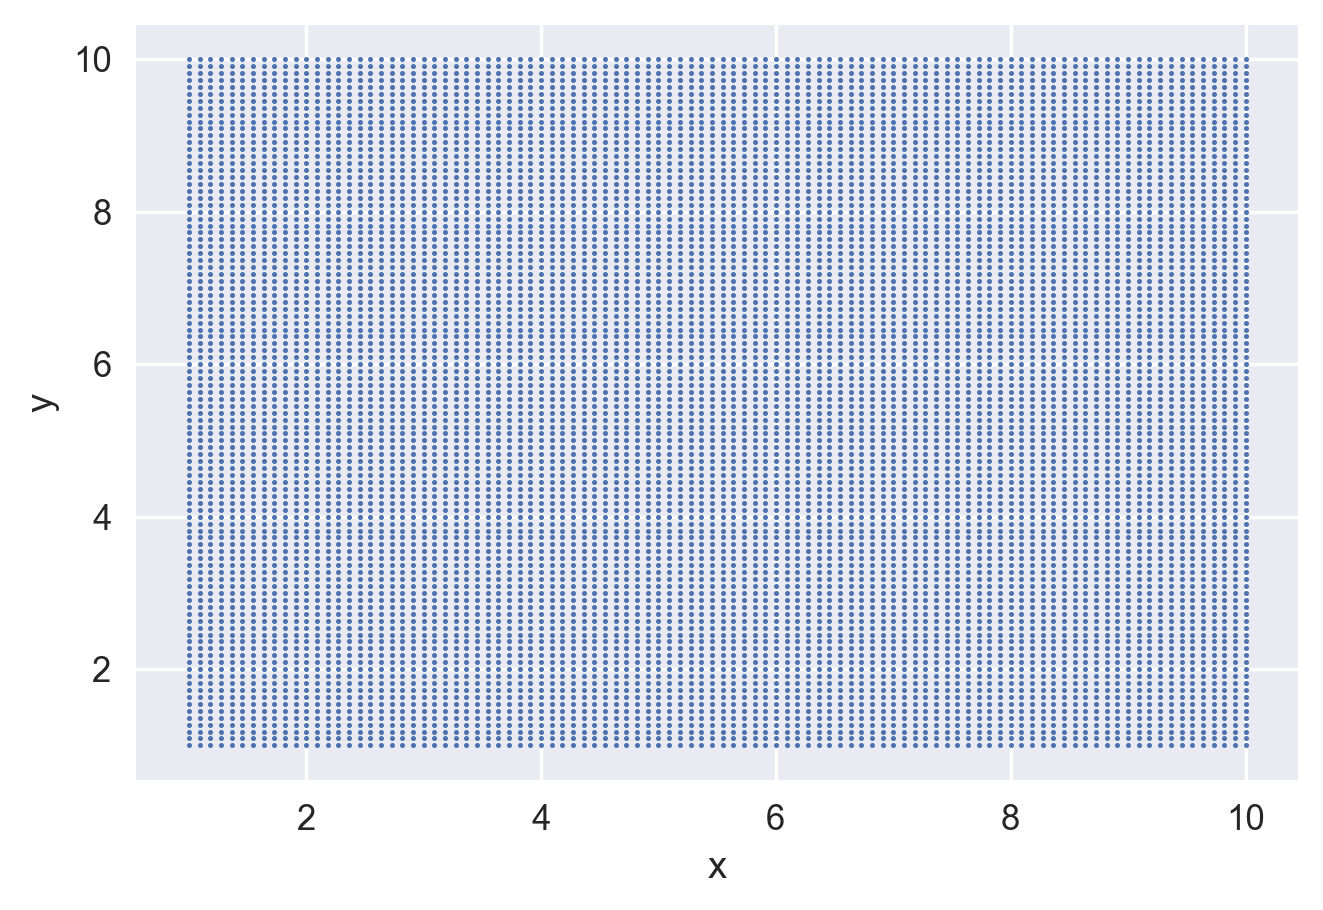

In [3]:
import matplotlib as mpl

%matplotlib inline

mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250

grid_points.plot(kind='scatter', x='x', y='y', marker='.', s=5)
plt.show()

**Cloud of Points:**

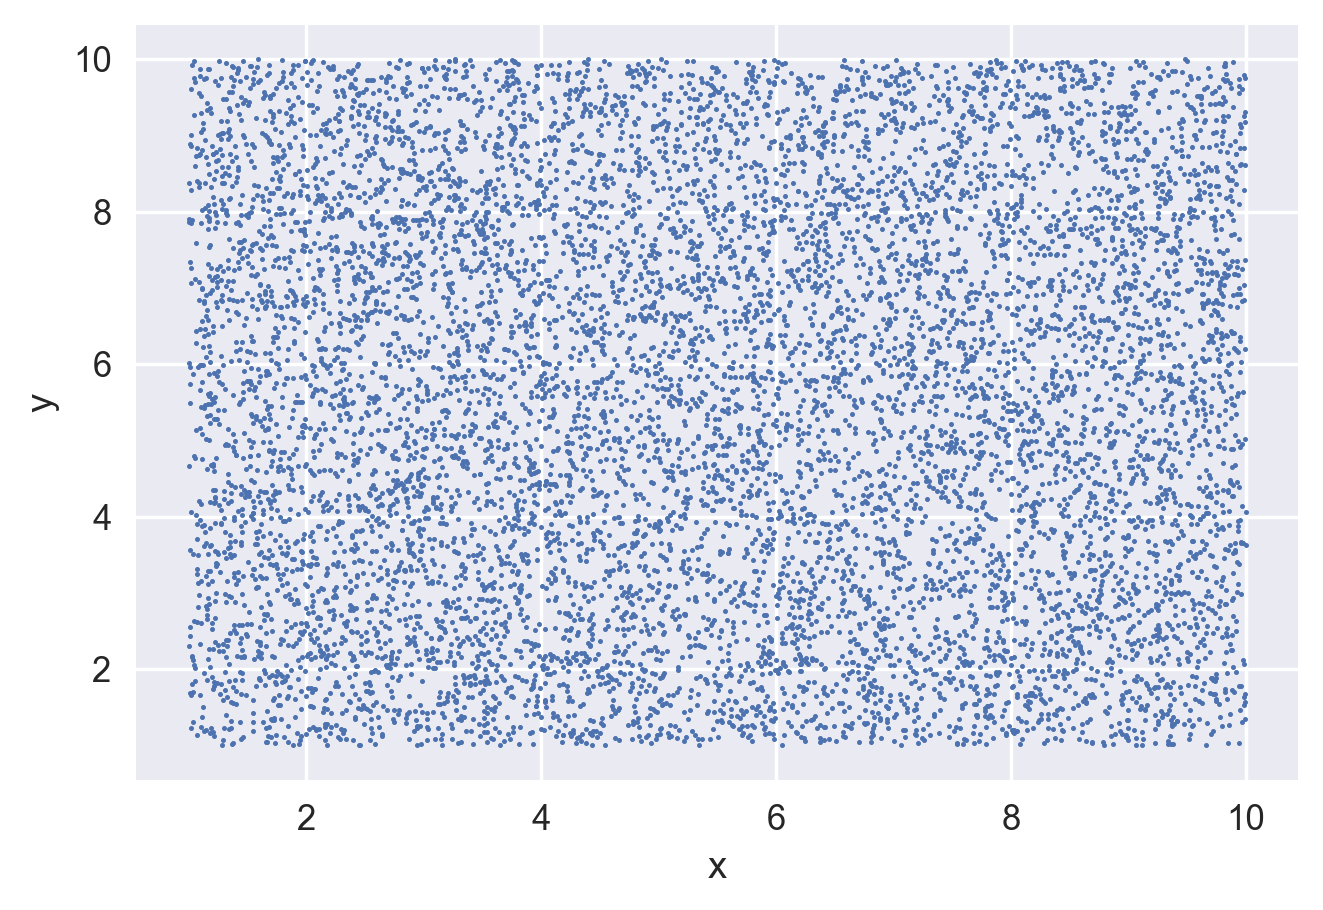

In [4]:
scattered_data_10000.plot(kind='scatter', x='x', y='y', marker='.', s=5)
plt.show()

## Applying KNN 

In [5]:
# Applying KNN
neighbors = NearestNeighbors(n_neighbors=number_neighbors, algorithm='ball_tree').fit(scattered_data_10000.loc[:, ['x', 'y']])

# Distance and index of each point from each vertice of the grid
distances, indexes = neighbors.kneighbors(grid_points.loc[:, ['x', 'y']])

## Calculating the radius which the nearest point has to be located (This part is necessary when the domain map was not informed)

| Symbol  | Meaning | 
|:------: |:-------:|
|$$ S_x $$| Step in X axis|
|$$ x_{max} $$| Maximum value of X in grid|
|$$ x_{max} $$| Minimum value of X in grid|
|$$ N_i $$ | Number of vertices in X axis|
|$$ S_y $$| Step in Y axis|
|$$ y_{max} $$| Maximum value of Y in grid|
|$$ y_{max} $$| Minimum value of Y in grid|
|$$ N_j $$ | Number of vertices in Y axis|
|$$ R $$ | Radius |
|$$ d_{norm} $$| Distance normalized|
|$$ n $$ | Number of neighbors|
|$$ w $$ | One minus the normalization, represent the weight of each distance |
|$$ P $$ | Result of the scalar points |
|$$ Z $$ | Represents the property value |

### Formula to calculate each axis step

$$ S_x = \frac{x_{max} - x_{min}}{N_i} $$

$$ S_y = \frac{y_{max} - y_{min}}{N_j} $$


### Formula to calculate the radius which will be the maximum distance which the first nearest point needs to be located

$$ R = 2\sqrt{S_x^2 + S_y^2} $$

In Python:

In [6]:
# Maximum and minimum values in X axis
max_x = grid_points.loc[:, 'x'].max()
min_x = grid_points.loc[:, 'x'].min()

# Maximum and minimum values in Y axis
max_y = grid_points.loc[:, 'y'].max()
min_y = grid_points.loc[:, 'y'].min()

# Step X and Step Y
step_x = (max_x - min_x) / NI
step_y = (max_y - min_y) / NJ

# Radius
radius = 2 * math.sqrt((step_x ** 2) + (step_y ** 2))

Selecting the points which the distance are equal or less than the radius:

In [7]:
less_radius = distances[:, 0] <= radius
distances = distances[less_radius, :]
indexes = indexes[less_radius, :]

### It is interesting to normalize the distance and subtract the value from 1.  That will be the weight of each distance.

Using the l2 normalization which can be represented by:
$$ d_{norm} = \frac{d}{\sqrt{\sum_{i=1}^{n} d_i}}  $$

The weight of each distance will be:

$$ w = 1 - d_{norm} $$

In python:

In [8]:
# Using the scikit-learn library
weight_norm = 1 - normalize(distances, axis=1)

### Formula to calculate the value for each vertice of the strcutured grid

$$ P = \frac{\sum_{i=1}^{n} (w_{i}\times Z_i)}{\sum_{j=1}^{n} w_{j}} $$

In Python:

In [9]:
prod = weight_norm * scattered_data_10000.values[indexes, 2]
scalars = np.full(NI * NJ, 0.0)
grid_points.loc[less_radius, 'z'] = prod.sum(axis=1) / (weight_norm.sum(axis=1))

## Example - Map desired

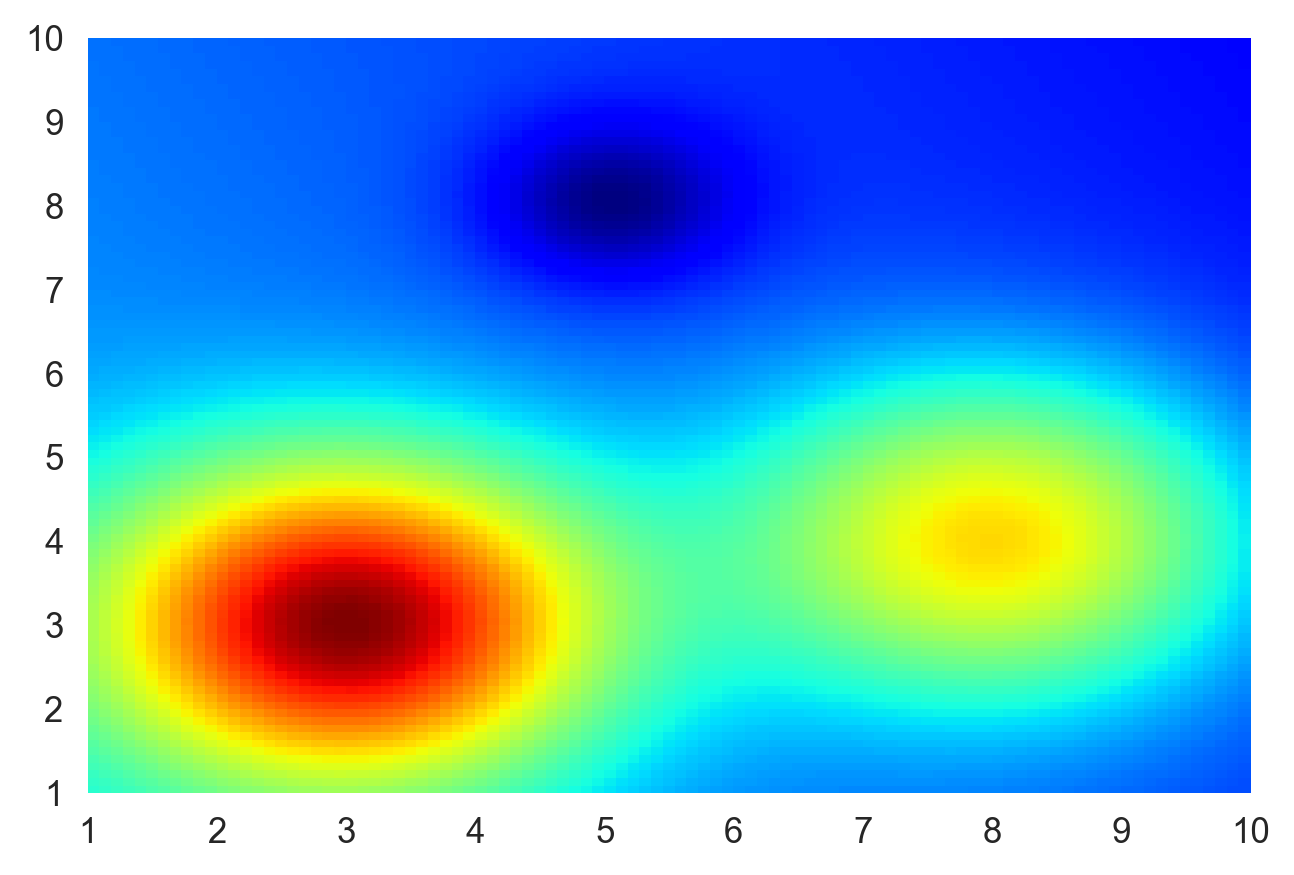

In [10]:
plt.pcolor(correct_map.values[:, 0].reshape(NI, NJ), correct_map.values[:, 1].reshape(NI, NJ), correct_map.values[:, 2].reshape(NI, NJ), cmap=cm.jet)

### Map reconstructed using the algorithm described

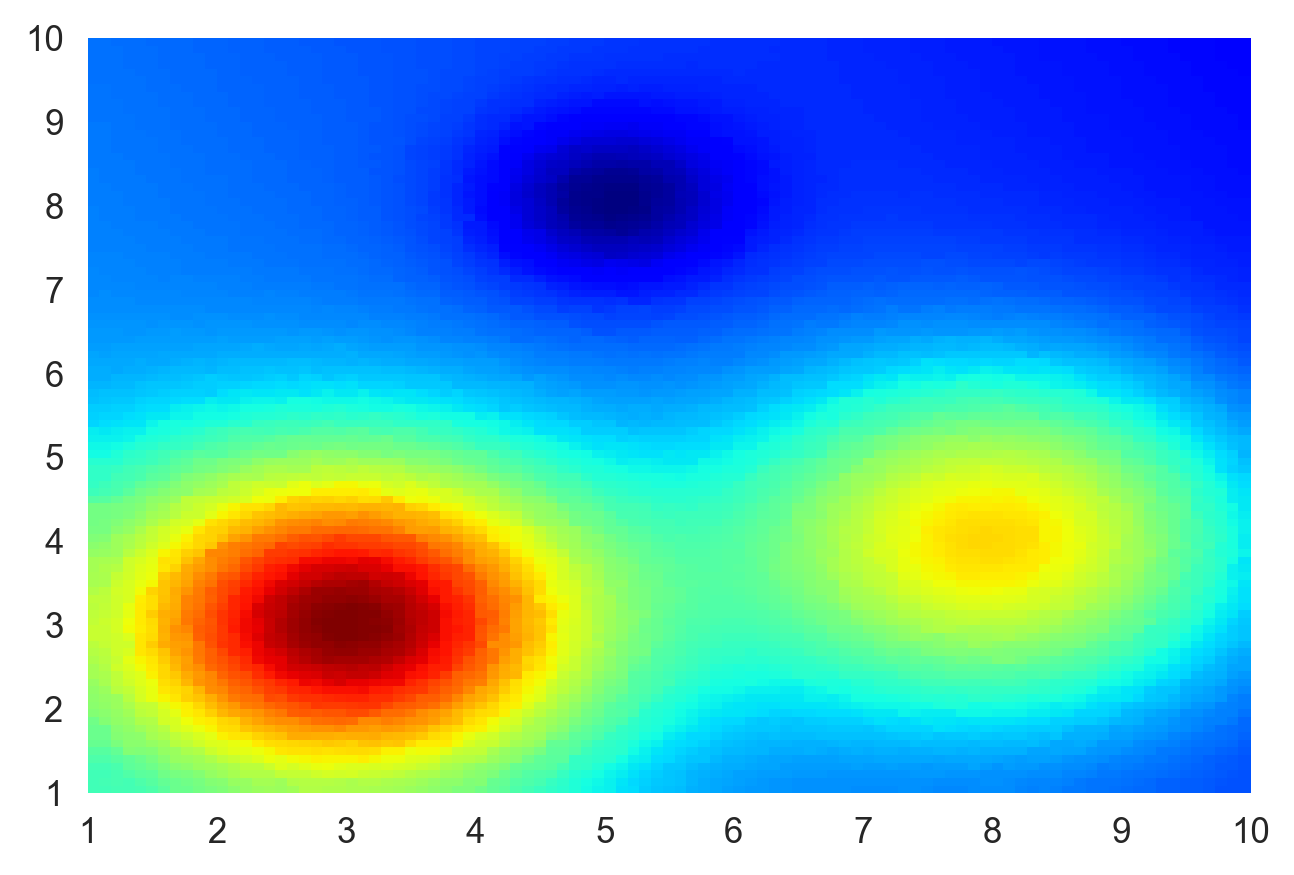

In [11]:
plt.pcolor(grid_points.values[:, 0].reshape(NI, NJ), grid_points.values[:, 1].reshape(NI, NJ), grid_points.values[:, 2].reshape(NI, NJ), cmap=cm.jet)

### Error

I'm going to calculate the error of the map reconstructed.

In [12]:
dif_map = correct_map.z - grid_points.z

In [13]:
dif_map.describe()

count    10000.000000
mean        -0.002056
std          0.040616
min         -0.374595
25%         -0.015490
50%         -0.000398
75%          0.012541
max          0.308697
Name: z, dtype: float64

In [14]:
error = (grid_points.z / correct_map.z) - 1

(array([  9.00000000e+00,   9.20000000e+01,   8.27000000e+02,
          6.53500000e+03,   2.12800000e+03,   3.30000000e+02,
          6.20000000e+01,   1.20000000e+01,   4.00000000e+00,
          1.00000000e+00]),
 array([-0.02799039, -0.02044437, -0.01289836, -0.00535234,  0.00219367,
         0.00973969,  0.0172857 ,  0.02483172,  0.03237773,  0.03992375,
         0.04746976]),
 <a list of 10 Patch objects>)

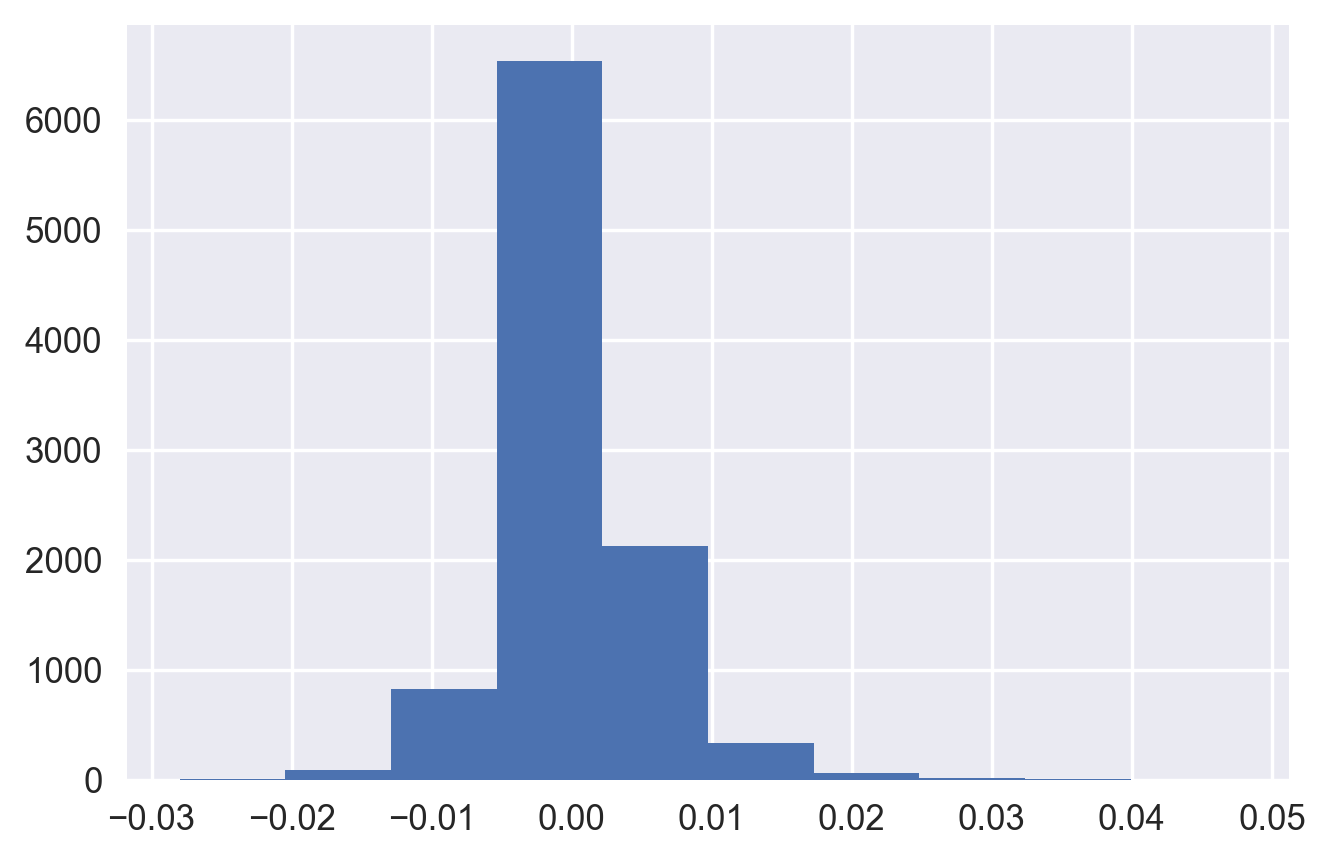

In [15]:
plt.hist(error)

In [16]:
error[error < 0] *= -1

In [17]:
error.describe()

count    1.000000e+04
mean     3.332213e-03
std      3.837730e-03
min      1.299330e-07
25%      6.622378e-04
50%      1.998104e-03
75%      4.668888e-03
max      4.746976e-02
Name: z, dtype: float64

Analyzing the histogram, the mean and the standard deviation we can see the mean error is something around 0.33% and the most part of the values is near to 0.46%.